
  gri30_He:

       temperature   296.15 K
          pressure   20000 Pa
           density   0.31087 kg/m^3
  mean mol. weight   38.274 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy             -1112            -42559  J
   internal energy            -65447       -2.5049e+06  J
           entropy            4450.3        1.7033e+05  J/K
    Gibbs function       -1.3191e+06       -5.0486e+07  J
 heat capacity c_p            555.97             21279  J/K
 heat capacity c_v            338.74             12965  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0021069              0.04           -20.559
                O2          0.016721              0.02           -30.208
                AR           0.98117              0.94           -20.29

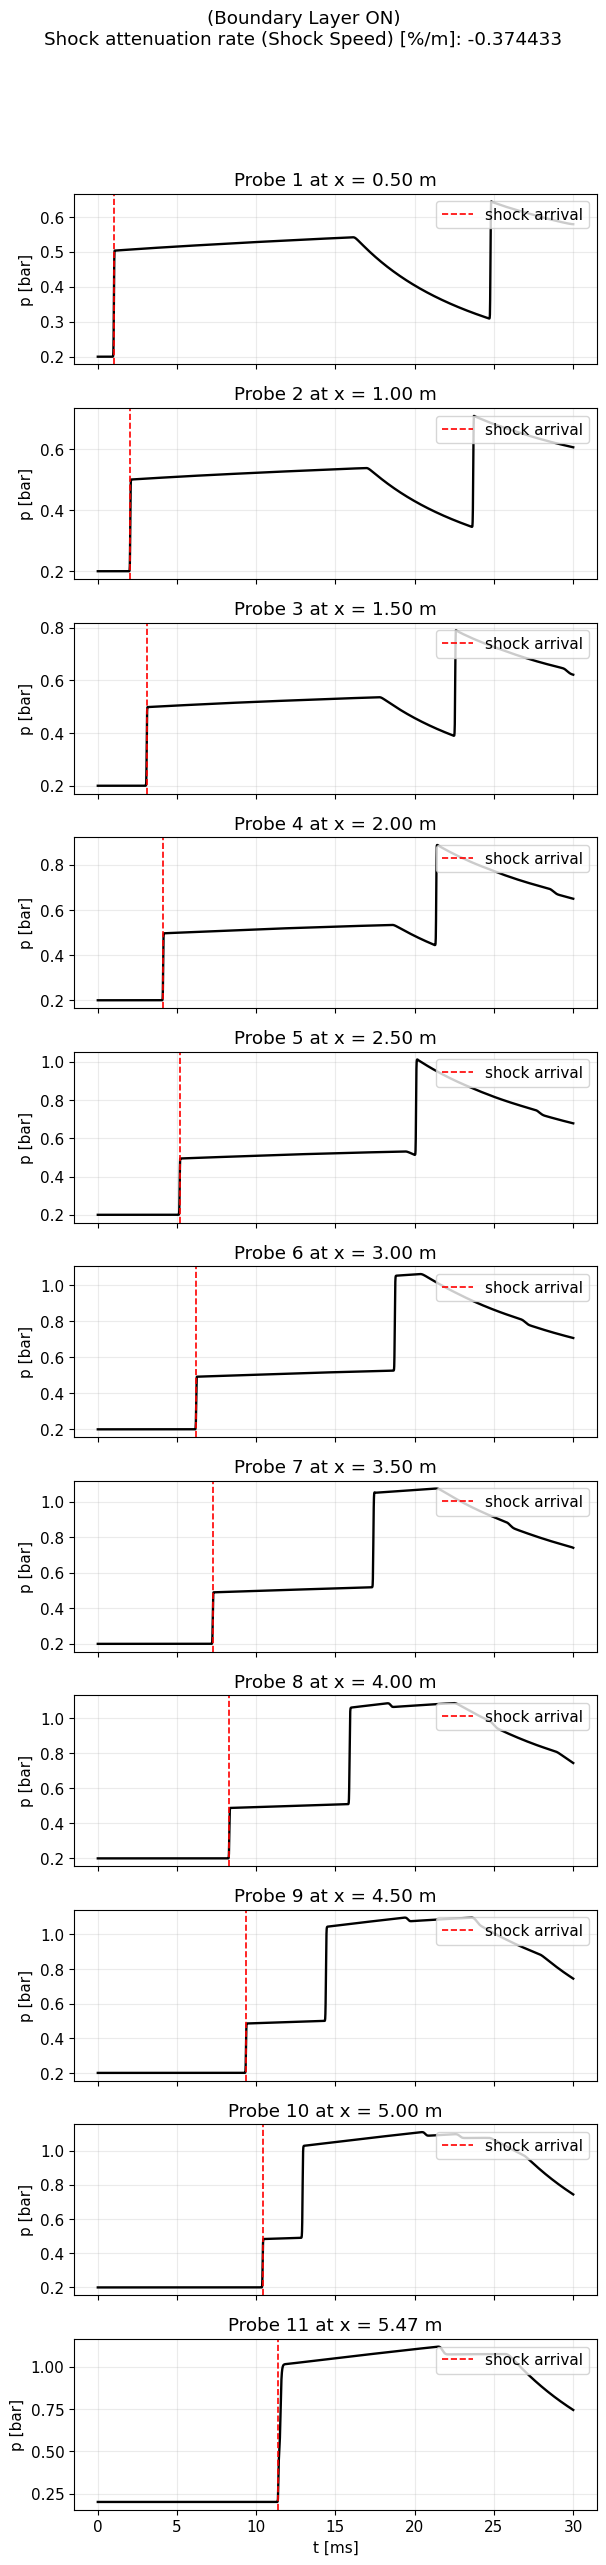

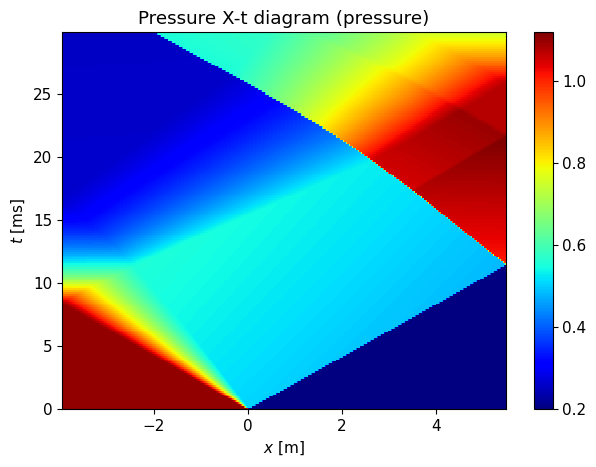

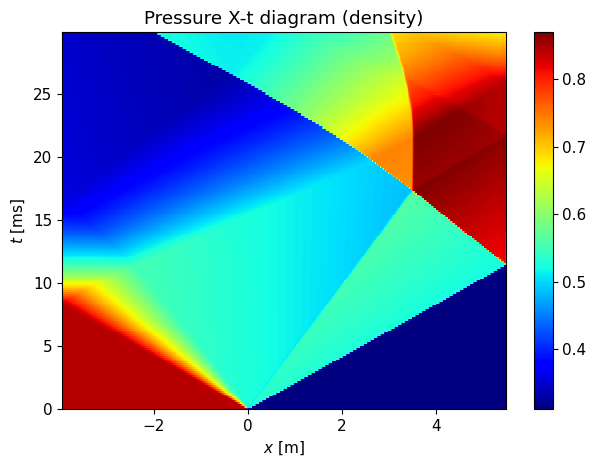

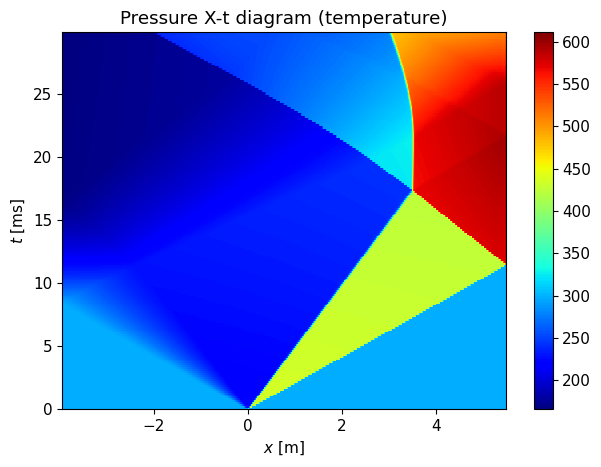

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
'''
    Copyright 2017 Kevin Grogan

    This file is part of StanShock.

    StanShock is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License.

    StanShock is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with StanShock.  If not, see <https://www.gnu.org/licenses/>.
'''
import os.path
from pathlib import Path
from typing import Optional, Sequence, Tuple

import cantera as ct
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from StanShock.stanShock import stanShock

#PROJECT_DIR = Path(__file__).resolve().parents[2]
PROJECT_DIR = Path.cwd().parents[2]

def _shock_metrics_from_probe(
    t: np.ndarray,
    p: np.ndarray,
    baseline_pressure: float,
    rise_fraction: float = 0.03,
) -> Tuple[float, float, float]:
    """
    Extract incident-shock arrival and strength from a probe trace.

    Shock-capturing logic used here:
    1) Estimate probe baseline pressure from the first ~5% of samples.
    2) Compute an adaptive rise threshold as:
         p_threshold = p_baseline + rise_fraction * (p_max - p_baseline)
       This intentionally allows detection of a *small first step* (incident shock)
       even when a larger reflected-shock jump appears later.
    3) Pick the first time index where pressure crosses p_threshold.
    4) Refine arrival to the strongest local dp/dt near that crossing.
    5) Compute shock pressure as the short-window mean right after arrival.
    """
    if len(t) < 10:
        raise RuntimeError("Probe trace is too short to determine shock metrics.")

    n0 = max(5, int(0.05 * len(p)))
    p_baseline = float(np.mean(p[:n0]))
    p_dynamic = float(np.max(p) - p_baseline)
    if p_dynamic <= 0.0:
        arrival_time = float(t[0])
        shock_pressure = p_baseline
        attenuation_metric = float(np.log(max(shock_pressure, 1e-12) / baseline_pressure))
        return arrival_time, shock_pressure, attenuation_metric

    p_threshold = p_baseline + rise_fraction * p_dynamic
    crossing = np.where(p >= p_threshold)[0]
    if len(crossing) == 0:
        i_cross = int(np.argmax(np.gradient(p, t)))
    else:
        i_cross = int(crossing[0])


    i_lo = max(1, i_cross - 5)
    i_hi = min(len(p) - 1, i_cross + 6)
    dpdt_local = np.gradient(p[i_lo:i_hi], t[i_lo:i_hi])
    i_shock = i_lo + int(np.argmax(dpdt_local))

    i1 = i_shock
    i2 = min(len(p), i_shock + 6)
    shock_pressure = float(np.mean(p[i1:i2]))
    arrival_time = float(t[i_shock])
    attenuation_metric = float(np.log(shock_pressure / baseline_pressure))
    return arrival_time, shock_pressure, attenuation_metric

def _gas_sound_speed(gas: ct.Solution) -> float:
    """Return sound speed with compatibility across Cantera versions."""
    if hasattr(gas, "sound_speed"):
        return float(gas.sound_speed)
    if hasattr(gas, "soundspeed"):
        return float(gas.soundspeed)
    gamma = gas.cp_mass / gas.cv_mass
    return float(np.sqrt(gamma * gas.P / gas.density))


def main(
        #PROJECT_DIR / "data/mechanisms/HeliumArgon.xml",
    mech_filename_gas_1: str = "gri30_He.yaml",
    mech_filename_gas_4: str = "gri30_He.yaml",
    show_results: bool = True,
    results_location: Optional[str] = None,
    t_final: float = 30e-3,
    n_x: int = 1000,
    cfl: float = 0.9,
    T1: float = 296.15,
    P1: float = 20000,
    T4: float = 296.15,
    P4: float = 110400,
    X1: Optional[str] = 'H2:4, O2:2, Ar:94', #4PctH2_2PctO2_94PctAr
    X4: Optional[str] = 'He:58.8971, Ar:41.1029', #'He:21.8787, N2:78.1213'
    Boundary_Layer_Model: bool = True,
    probe_locations: Sequence[float] = (0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.47)

) -> None:
    ct.add_directory(PROJECT_DIR)
    # simulation controls
    tFinal = t_final

    # plotting parameters
    fontsize = 11

    # provided geometry
    DDriven = 122.24/1000 #m
    DDriver = DDriven
    LDriver = 3.96 #m
    LDriven = 5.49 #m

    # Set up gases from user-provided initial states
    u1 = 0.0
    u4 = 0.0  # initially 0 velocity
    gas1 = ct.Solution(mech_filename_gas_1)
    gas4 = ct.Solution(mech_filename_gas_4)

    if X1 is None:
        gas1.TP = T1, P1
    else:
        gas1.TPX = T1, P1, X1

    if X4 is None:
        gas4.TP = T4, P4
    else:
        gas4.TPX = T4, P4, X4

    print(gas1())
    gas1_gamma = gas1.cp_mass/gas1.cv_mass
    print(gas1.cp_mass)
    print(gas1.cv_mass)
    print(gas1_gamma)
    print(gas4())
    gas4_gamma = gas4.cp_mass / gas4.cv_mass
    print(gas4.cp_mass)
    print(gas4.cv_mass)
    print(gas4_gamma)

    # set up geometry
    nX = n_x  # mesh resolution
    xLower = -LDriver
    xUpper = LDriven
    xShock = 0.0
    geometry = (nX, xLower, xUpper, xShock)
    DeltaD = DDriven - DDriver
    DeltaX = (xUpper - xLower) / float(nX) * 10  # diffuse area change for numerical stability

    def D(x):
        diameter = DDriven + (DeltaD / DeltaX) * (x - xShock)
        diameter[x < (xShock - DeltaX)] = DDriver
        diameter[x > xShock] = DDriven
        return diameter

    def dDdx(x):
        dDiameterdx = np.ones(len(x)) * (DeltaD / DeltaX)
        dDiameterdx[x < (xShock - DeltaX)] = 0.0
        dDiameterdx[x > xShock] = 0.0
        return dDiameterdx

    A = lambda x: np.pi / 4.0 * D(x) ** 2.0
    dAdx = lambda x: np.pi / 2.0 * D(x) * dDdx(x)
    dlnAdx = lambda x, t: dAdx(x) / A(x)

    if Boundary_Layer_Model == True:
        # Turn ON boundary-layer model as requested
        print("Solving with boundary layer model")
    else:
        print("Solving without boundary layer model")

    boundaryConditions = ["reflecting", "reflecting"]
    state1 = (gas1, u1)
    state4 = (gas4, u4)
    ssbl = stanShock(
        gas1,
        initializeRiemannProblem=(state4, state1, geometry),
        boundaryConditions=boundaryConditions,
        cfl=cfl,
        outputEvery=100,
        includeBoundaryLayerTerms=Boundary_Layer_Model,
        DOuter=D,
        Tw=T1,  # assume wall temperature is in thermal eq. with gas
        dlnAdx=dlnAdx,
    )

    # Attenuation probes in the driven section
    for i, x_probe in enumerate(probe_locations):
        ssbl.addProbe(x_probe, probeName=f"probe_{i+1}")


    # X-t diagram for pressure
    ssbl.addXTDiagram("pressure", skipSteps=10)
    ssbl.addXTDiagram("density", skipSteps=10)
    ssbl.addXTDiagram("temperature", skipSteps=10)
    # Solve
    ssbl.advanceSimulation(tFinal)

    # --- Post-processing: attenuation from multi-probe data ---
    arrivals = []
    shock_pressures = []
    attenuation_values = []

    for probe in ssbl.probes[:len(probe_locations)]:
        t_probe = np.array(probe.t)
        p_probe = np.array(probe.p)
        arrival_t, p_shock, attn = _shock_metrics_from_probe(t_probe, p_probe, P1)
        arrivals.append(arrival_t)
        shock_pressures.append(p_shock)
        attenuation_values.append(attn)

    x_probe = np.array(probe_locations)
    arrivals = np.array(arrivals)
    shock_pressures = np.array(shock_pressures)
    attenuation_values = np.array(attenuation_values)


    # attenuation rate based on ln(p_shock/p1) vs x
    attenuation_rate, attenuation_intercept = np.polyfit(x_probe, attenuation_values, 1)

    # average shock speed from x(t_arrival)
    x_t_slope, x_t_intercept = np.polyfit(arrivals, x_probe, 1)

    # shock-speed attenuation from probe-to-probe travel times
    dt_seg = np.diff(arrivals)
    dx_seg = np.diff(x_probe)
    valid_seg = dt_seg > 0.0
    if np.count_nonzero(valid_seg) >= 2:
        x_seg = 0.5 * (x_probe[:-1][valid_seg] + x_probe[1:][valid_seg])
        us_seg = dx_seg[valid_seg] / dt_seg[valid_seg]
        us_attenuation_rate, us_intercept = np.polyfit(x_seg, us_seg, 1)

        a1 = _gas_sound_speed(gas1)
        ms_seg = us_seg / a1
        ms_attenuation_rate, ms_intercept = np.polyfit(x_seg, ms_seg, 1)

        us_percent_attenuation_rate = 100.0 * us_attenuation_rate / us_intercept if us_intercept != 0.0 else np.nan
    else:
        x_seg = np.array([])
        us_seg = np.array([])
        ms_seg = np.array([])
        us_attenuation_rate = np.nan
        us_intercept = np.nan
        ms_attenuation_rate = np.nan
        ms_intercept = np.nan
        us_percent_attenuation_rate = np.nan

    print("\n==== Shock Probes ====")
    print("Initial state driven  (T1 [K], P1 [Pa]):", (T1, P1))
    print("Initial state driver  (T4 [K], P4 [Pa]):", (T4, P4))
    print("Probe positions [m]:", x_probe)
    print("Shock arrival times [ms]:", arrivals * 1e3)
    print("Shock pressures [bar]:", shock_pressures / 1e5)
    #print("ln(p_shock/p1):", attenuation_values)
    #print("Attenuation rate dln(p_shock/P1)/dx [1/m]: %.6f" % attenuation_rate)
    print("Average shock speed from x(t_arrival) [m/s]: %.3f" % x_t_slope)
    if len(us_seg) > 0:
        print("Segment centers x [m]:", x_seg)
        print("Segment shock speeds U_s [m/s]:", us_seg)
    if Boundary_Layer_Model == True:
        if np.isfinite(us_attenuation_rate):
            print("Shock-speed attenuation dU_s/dx [(m/s)/m]: %.6f" % us_attenuation_rate)
        else:
            print("Shock-speed attenuation dU_s/dx [(m/s)/m]: unavailable (insufficient valid probe segments)")
        if np.isfinite(us_percent_attenuation_rate):
            print("Percent speed-change attenuation (slope/intercept*100) [%%/m]: %.6f" % us_percent_attenuation_rate)
        else:
            print("Percent speed-change attenuation (slope/intercept*100) [%%/m]: unavailable")
        if np.isfinite(ms_attenuation_rate):
            print("Mach attenuation dM_s/dx [1/m]: %.6f" % ms_attenuation_rate)
        else:
            print("Mach attenuation dM_s/dx [1/m]: unavailable (insufficient valid probe segments)")

    # --- Plots ---
    plt.close("all")
    mpl.rcParams["font.size"] = fontsize

    # Probe graphs in one figure
    n_probe_plot = len(probe_locations)
    fig, axes = plt.subplots(n_probe_plot, 1, figsize=(6.2, 2.25 * n_probe_plot + 1.0), sharex=True)
    if n_probe_plot == 1:
        axes = np.array([axes])
    for i, probe in enumerate(ssbl.probes[:n_probe_plot]):
        t_probe = np.array(probe.t)
        p_probe = np.array(probe.p)
        axes[i].plot(t_probe * 1000.0, p_probe / 1.0e5, "k", linewidth=1.7)
        axes[i].axvline(arrivals[i] * 1000.0, color="r", linestyle="--", linewidth=1.2, label="shock arrival")
        axes[i].set_ylabel("p [bar]")
        axes[i].set_title("Probe %d at x = %.2f m" % (i + 1, probe_locations[i]))
        axes[i].grid(alpha=0.25)
        axes[i].legend(loc="upper right")
    axes[-1].set_xlabel("t [ms]")
    if Boundary_Layer_Model == True:
        fig.suptitle(
            "(Boundary Layer ON)\nShock attenuation rate (Shock Speed) [%%/m]: %.6f" % us_percent_attenuation_rate,
            y=0.995,
        )
        fig.tight_layout(rect=[0, 0, 1, 0.96])
    else:
        fig.suptitle(
            "(Boundary Layer OFF)",
            y=0.995,
        )
        fig.tight_layout(rect=[0, 0, 1, 0.96])

    # X-t diagram for pressure
    ssbl.plotXTDiagram(ssbl.XTDiagrams["pressure"])
    plt.title("Pressure X-t diagram (pressure)")
    plt.tight_layout()

    ssbl.plotXTDiagram(ssbl.XTDiagrams["density"])
    plt.title("Pressure X-t diagram (density)")
    plt.tight_layout()

    ssbl.plotXTDiagram(ssbl.XTDiagrams["temperature"])
    plt.title("Pressure X-t diagram (temperature)")
    plt.tight_layout()

    if show_results:
        plt.show()

    if results_location is not None:
        np.savez(
            os.path.join(results_location, "case1_attenuation.npz"),
            probe_locations=x_probe,
            probe_arrival_times=arrivals,
            probe_shock_pressures=shock_pressures,
            probe_attenuation=attenuation_values,
            T1=T1,
            P1=P1,
            T4=T4,
            P4=P4,
            attenuation_rate=attenuation_rate,
            attenuation_intercept=attenuation_intercept,
            shock_speed_average=x_t_slope,
            shock_speed_intercept=x_t_intercept,
            shock_speed_segment=us_seg,
            shock_speed_attenuation_rate=us_attenuation_rate,
            shock_speed_attenuation_intercept=us_intercept,
            shock_speed_percent_attenuation_rate=us_percent_attenuation_rate,
            shock_mach_segment=ms_seg,
            shock_mach_attenuation_rate=ms_attenuation_rate,
            shock_mach_attenuation_intercept=ms_intercept,
            xt_time=np.array(ssbl.XTDiagrams["pressure"].t),
            xt_x=np.array(ssbl.XTDiagrams["pressure"].x),
            xt_pressure=np.array(ssbl.XTDiagrams["pressure"].variable),
        )
        fig.savefig(os.path.join(results_location, "case1_attenuation_probes.png"), dpi=200)
        plt.figure(2)
        plt.savefig(os.path.join(results_location, "case1_attenuation_xt.png"), dpi=200)


if __name__ == "__main__":
    main()


NameError: name 'us_seg' is not defined